#Lab session 7: Learning on Sets / Learning with Proteins

## learning objective 

The goal of this lab is to introduce you to machine learning models for data represented as sets. Furthermore, you will deal with a problem that arises in the field of bio-informatics and which can be solved using machine learning techniques. Specifically, in the first part of the lab, we will implement
the *DeepSets* model. We will evaluate the model in the task of computing the sum of sets of digits and compare it against traditional models such as LSTMs. In the second part of the lab, you will learn how proteins can be represented as graphs, and you will implement a graph neural networks (GNN) to deal with the antibiotic resistance classification task. We will use Python, and the following three libraries:(1) PyTorch (https://pytorch.org/), (2) NetworkX (http://networkx.github.io/), and (3) Graphein (https://graphein.ai/).

## Imports

In [1]:
#!pip install graphein

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#utils
import numpy as np
import scipy.sparse as sp


#models 
import torch
import torch.nn as nn
import torch.nn.functional as F

#train 
import time
import torch.optim as optim

#eval
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
#pdp
from functools import partial

from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.visualisation import plot_protein_structure_graph
from graphein.protein.analysis import plot_degree_by_residue_type, plot_edge_type_distribution, plot_residue_composition
from graphein.protein.edges.distance import add_peptide_bonds, add_hydrogen_bond_interactions, add_disulfide_interactions, add_ionic_interactions, add_aromatic_interactions, add_aromatic_sulphur_interactions, add_cation_pi_interactions, add_distance_threshold, add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot, expasy_protein_scale, meiler_embedding
from graphein.protein.utils import download_alphafold_structure


#drive
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/MVA/ALTEGRAD/labs/lab7/code')

To do so, use the following command: pip install biovec
pytorch3d cannot be installed via pip


[12/17/22 14:57:42] WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=164005;file:///usr/local/lib/python3.8/dist-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=542626;file:///usr/local/lib/python3.8/dist-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

Mounted at /content/drive/


In [21]:
os.chdir('/content/drive/MyDrive/MVA/ALTEGRAD/labs/lab7/code')

# Part 1: DeepSets

## Dataset Generation

### task 1

In [4]:
def create_train_dataset():
    n_train = 100000
    max_train_card = 10

    ############## Task 1
    
    ##################
    X_train=np.zeros((n_train,max_train_card))
    y_train=np.zeros(n_train)
    for i in range(n_train):
      card=np.random.randint(1,max_train_card+1)
      X_train[i,-card:]=np.random.randint(1,max_train_card+1, size=card)
      y_train[i]=np.sum(X_train[i,:])
    
    print('First training sample', X_train[0,:])
    print('First target  training sample', y_train[0])
    ##################

    return X_train, y_train


### task 2

In [5]:
def create_test_dataset():
    
    ############## Task 2
    
    ##################
    n_test=200000
    min_test_card=5
    max_test_card=101
    step_test_card=5
    cards=range(min_test_card,max_test_card,step_test_card)
    n_samples_per_card=n_test//len(cards)

    X_test=list()
    y_test=list()

    for card in cards:
      X=np.random.randint(1,11,size=(n_samples_per_card,card))
      y=np.sum(X,axis=1)

      X_test.append(X)
      y_test.append(y)
    ##################

    return X_test, y_test

## Implementation of DeepSets

### task 3

In [6]:
class DeepSets(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(DeepSets, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        
        ############## Task 3
    
        ##################
        x=self.embedding(x)
        x=self.tanh(self.fc1(x))
        x=torch.sum(x,dim=1)
        x=self.fc2(x)
        ##################
        
        return x.squeeze()


### task 4

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        
        ############## Task 4
    
        ##################
        x=self.embedding(x)
        _,(x,_)=self.lstm(x) #all embedding, (last embedding, final cell state )
        x=self.fc(x)
        ##################
        
        return x.squeeze()

## Model Training

### task 5

In [8]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 20
batch_size = 64
embedding_dim = 128
hidden_dim = 64
learning_rate = 0.001

# Generates training data
X_train, y_train = create_train_dataset()
n_train = 100000
n_digits = 11

# Initializes DeepSets model and optimizer
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(deepsets.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()


First training sample [ 0.  0.  0.  0.  0.  0.  4. 10.  3.  8.]
First target  training sample 25.0


In [9]:
# Trains the DeepSets model
for epoch in range(epochs):
    t = time.time()
    deepsets.train()
     
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
        
        ############## Task 5
    
        ##################
        x_batch=X_train[idx[i: min(i+batch_size,n_train)],:]
        y_batch=y_train[idx[i: min(i+batch_size,n_train)]]
        #to tensors 

        x_batch=torch.LongTensor(x_batch).to(device)
        y_batch=torch.FloatTensor(y_batch).to(device)
        ##################
        
        optimizer.zero_grad()
        output = deepsets(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores DeepSets model into disk
torch.save({
    'state_dict': deepsets.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_deepsets.pth.tar')

print("Finished training for DeepSets model")
print()

# Initializes LSTM model and optimizer
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the LSTM model
for epoch in range(epochs):
    t = time.time()
    lstm.train()
     
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
    
        ############## Task 5
        
        ##################
        x_batch=X_train[idx[i: min(i+batch_size,n_train)],:]
        y_batch=y_train[idx[i: min(i+batch_size,n_train)]]
        #to tensors 

        x_batch=torch.LongTensor(x_batch).to(device)
        y_batch=torch.FloatTensor(y_batch).to(device)
        ##################
        
        optimizer.zero_grad()
        output = lstm(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores LSTM model into disk
torch.save({
    'state_dict': lstm.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_lstm.pth.tar')

print("Finished training for LSTM model")

Epoch: 0001 loss_train: 1.0738 time: 3.4891s
Epoch: 0002 loss_train: 0.0615 time: 7.2164s
Epoch: 0003 loss_train: 0.0498 time: 6.3429s
Epoch: 0004 loss_train: 0.0440 time: 7.5887s
Epoch: 0005 loss_train: 0.0370 time: 5.3399s
Epoch: 0006 loss_train: 0.0363 time: 3.2281s
Epoch: 0007 loss_train: 0.0314 time: 3.1941s
Epoch: 0008 loss_train: 0.0304 time: 3.2360s
Epoch: 0009 loss_train: 0.0302 time: 3.2471s
Epoch: 0010 loss_train: 0.0295 time: 3.2387s
Epoch: 0011 loss_train: 0.0287 time: 3.2524s
Epoch: 0012 loss_train: 0.0285 time: 3.1889s
Epoch: 0013 loss_train: 0.0264 time: 3.2166s
Epoch: 0014 loss_train: 0.0256 time: 4.5276s
Epoch: 0015 loss_train: 0.0253 time: 4.1493s
Epoch: 0016 loss_train: 0.0265 time: 3.2307s
Epoch: 0017 loss_train: 0.0277 time: 3.2771s
Epoch: 0018 loss_train: 0.0265 time: 3.1755s
Epoch: 0019 loss_train: 0.0270 time: 3.2400s
Epoch: 0020 loss_train: 0.0252 time: 3.2386s
Finished training for DeepSets model

Epoch: 0001 loss_train: 6.3399 time: 14.0482s
Epoch: 0002 loss

## Predicting the Sum of a Set of Digits

### task 6

In [10]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
batch_size = 64
embedding_dim = 128
hidden_dim = 64

# Generates test data
X_test, y_test = create_test_dataset()
cards = [X_test[i].shape[1] for i in range(len(X_test))]
n_samples_per_card = X_test[0].shape[0]
n_digits = 11

# Retrieves DeepSets model
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading DeepSets checkpoint!")
checkpoint = torch.load('model_deepsets.pth.tar')
deepsets.load_state_dict(checkpoint['state_dict'])
deepsets.eval()

# Retrieves LSTM model
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading LSTM checkpoint!")
checkpoint = torch.load('model_lstm.pth.tar')
lstm.load_state_dict(checkpoint['state_dict'])
lstm.eval()

Loading DeepSets checkpoint!
Loading LSTM checkpoint!


LSTM(
  (embedding): Embedding(11, 128)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
# Dict to store the results
results = {'deepsets': {'acc':[], 'mae':[]}, 'lstm': {'acc':[], 'mae':[]}}

for i in range(len(cards)):
    y_pred_deepsets = list()
    y_pred_lstm = list()
    for j in range(0, n_samples_per_card, batch_size):
        
        ############## Task 6
    
        ##################
        x_batch=X_test[i][j:min(j+batch_size,n_samples_per_card),:]
        y_batch=y_test[i][j:min(j+batch_size,n_samples_per_card)]

        x_batch=torch.LongTensor(x_batch).to(device)
        y_batch=torch.FloatTensor(y_batch).to(device)

        output_deepsets=deepsets(x_batch)
        y_pred_deepsets.append(output_deepsets)

        output_lstm=lstm(x_batch)
        y_pred_lstm.append(output_lstm)
        ##################
        
    y_pred_deepsets = torch.cat(y_pred_deepsets)
    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()
    
    acc_deepsets = accuracy_score(y_test[i],np.round(y_pred_deepsets))#your code here
    mae_deepsets = mean_absolute_error(y_test[i],y_pred_deepsets)#your code here
    results['deepsets']['acc'].append(acc_deepsets)
    results['deepsets']['mae'].append(mae_deepsets)
    
    y_pred_lstm = torch.cat(y_pred_lstm)
    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()
    
    acc_lstm =accuracy_score(y_test[i],np.round(y_pred_lstm)) #your code here
    mae_lstm = mean_absolute_error(y_test[i],y_pred_lstm)#your code here
    results['lstm']['acc'].append(acc_lstm)
    results['lstm']['mae'].append(mae_lstm)



### task 7

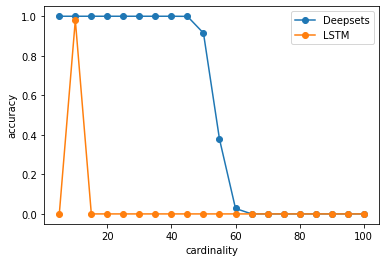

In [12]:
############## Task 7
import matplotlib.pyplot as plt   
##################
plt.plot(cards, results['deepsets']['acc'],'-o',label='Deepsets')
plt.plot(cards, results['lstm']['acc'],'-o',label='LSTM')

plt.xlabel('cardinality')
plt.ylabel('accuracy')

plt.legend()
plt.show()

##################

# Part 2: Learning with Proteins

## Protein Graph Model

### task 8

In [13]:
# Configuration object for graph construction
config = ProteinGraphConfig(**{"node_metadata_functions": [amino_acid_one_hot, 
                                                           expasy_protein_scale,
                                                           meiler_embedding],
                               "edge_construction_functions": [add_peptide_bonds,
                                                  add_aromatic_interactions,
                                                  add_hydrogen_bond_interactions,
                                                  add_disulfide_interactions,
                                                  add_ionic_interactions,
                                                  add_aromatic_sulphur_interactions,
                                                  add_cation_pi_interactions,
                                                  partial(add_distance_threshold, long_interaction_threshold=5, threshold=10.),
                                                  partial(add_k_nn_edges, k=3, long_interaction_threshold=2)],
                               })

PDB_CODE = "Q5VSL9"

In [14]:
############## Task 8
    
##################
protein_path = download_alphafold_structure(PDB_CODE , aligned_score=False)
G=construct_graph(pdb_path=protein_path,config=config)
##################

# Print number of nodes and number of edges
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())


Output()

/usr/local/lib/python3.8/dist-packages/biopandas/pdb/pandas_pdb.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idxs["end_idx"] = ends.line_idx.values

Number of nodes: 837
Number of edges: 4258


### task 9

In [26]:
############## Task 9
    
##################
degree_seq=[G.degree(node) for node in G.nodes()]
print('Max degree', np.max(degree_seq))

plot_degree_by_residue_type(G)
##################

Max degree 25


In [27]:
plot_edge_type_distribution(G)

In [28]:
plot_residue_composition(G)

<Axes3D: >

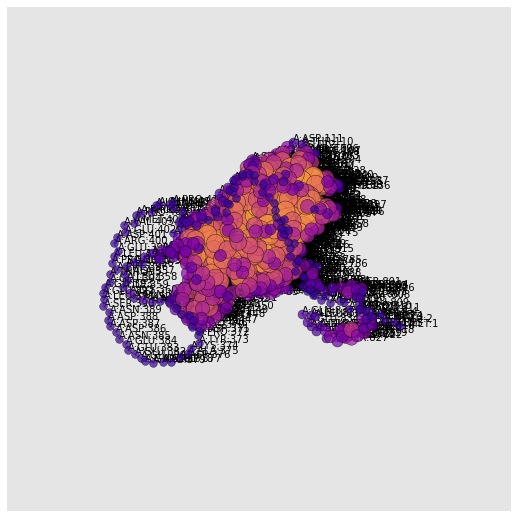

In [29]:
plot_protein_structure_graph(G)

## Antibiotic Resistance Classification

### task 10

In [16]:
class GNN(nn.Module):
    """
    Simple message passing model that consists of 2 message passing layers
    and the sum aggregation function
    """
    def __init__(self, input_dim, hidden_dim, dropout, n_class):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, n_class)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_in, adj, idx):
        
        ############## Task 10
    
         ##################
        # a message passing layer followed by a ReLU activation function
        x = self.fc1(x_in)
        x = self.relu(x)
        x = self.dropout(x)
        #a message passing layer
        x = self.fc2(x)
        ##################
        
        x = torch.matmul(adj, x)
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1)).to(x_in.device)
        out = out.scatter_add_(0, idx, x)
        
        ##################
        #a batch normalization layer
        out = self.bn(out)
        #a message passing layer followed by a ReLU activation function
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        #a message passing layer
        out = self.fc4(out)

        ##################

        return F.log_softmax(out, dim=1)


### utils

In [22]:
def load_data(): 
    """
    Function that loads graphs
    """  
    graph_indicator = np.loadtxt("./data/graph_indicator.txt", dtype=np.int64)
    _,graph_size = np.unique(graph_indicator, return_counts=True)
    
    edges = np.loadtxt("./data/edgelist.txt", dtype=np.int64, delimiter=",")
    A = sp.csr_matrix((np.ones(edges.shape[0]), (edges[:,0], edges[:,1])), shape=(graph_indicator.size, graph_indicator.size))
    A += A.T
    
    x = np.loadtxt("./data/node_attributes.txt", delimiter=",")
    edge_attr = np.loadtxt("./data/edge_attributes.txt", delimiter=",")
    graph_labels = np.loadtxt("./data/graph_labels.txt", dtype=np.int64)
    
    adj = []
    features = []
    edge_features = []
    idx_n = 0
    idx_m = 0
    for i in range(graph_size.size):
        adj.append(A[idx_n:idx_n+graph_size[i],idx_n:idx_n+graph_size[i]])
        edge_features.append(edge_attr[idx_m:idx_m+adj[i].nnz,:])
        features.append(x[idx_n:idx_n+graph_size[i],:])
        idx_n += graph_size[i]
        idx_m += adj[i].nnz

    return adj, features, edge_features, graph_labels

def normalize_adjacency(A):
    """
    Function that normalizes an adjacency matrix
    """
    n = A.shape[0]
    A = A + sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D = sp.diags(inv_degs)
    A_normalized = D.dot(A)

    return A_normalized

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Function that converts a Scipy sparse matrix to a sparse Torch tensor
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### task 11

In [23]:
from sklearn.model_selection import train_test_split
# Load graphs
adj, features, edge_features, y = load_data() 

# Normalize adjacency matrices
adj = [normalize_adjacency(A) for A in adj]

# Split data into training and test sets
adj_train, adj_test, features_train, features_test, y_train, y_test = train_test_split(adj, features, y, test_size=0.1)

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 50
batch_size = 64
n_hidden = 64
n_input = 23
dropout = 0.2
learning_rate = 0.001
n_class = 2

# Compute number of training and test samples
N_train = len(adj_train)
N_test = len(adj_test)

# Initializes model and optimizer
model = GNN(n_input, n_hidden, dropout, n_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Train model
for epoch in range(epochs):
    t = time.time()
    model.train()
    train_loss = 0
    correct = 0
    count = 0
    # Iterate over the batches
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        features_batch = list()
        idx_batch = list()
        y_batch = list()
        
        # Create tensors
        for j in range(i, min(N_train, i+batch_size)):
            n = adj_train[j].shape[0]
            adj_batch.append(adj_train[j]+sp.identity(n))
            features_batch.append(features_train[j])
            idx_batch.extend([j-i]*n)
            y_batch.append(y_train[j])
            
        adj_batch = sp.block_diag(adj_batch)
        features_batch = np.vstack(features_batch)

        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
        features_batch = torch.FloatTensor(features_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)
        
        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        print('Epoch: {:03d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
# Evaluate model
model.eval()
test_loss = 0
correct = 0
count = 0
# Iterate over the batches
for i in range(0, N_test, batch_size):
    adj_batch = list()
    features_batch = list()
    idx_batch = list()
    y_batch = list()
    
    # Create tensors
    for j in range(i, min(N_test, i+batch_size)):
        n = adj_test[j].shape[0]
        adj_batch.append(adj_test[j]+sp.identity(n))
        features_batch.append(features_test[j])
        idx_batch.extend([j-i]*n)
        y_batch.append(y_test[j])
        
    adj_batch = sp.block_diag(adj_batch)
    features_batch = np.vstack(features_batch)

    adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
    features_batch = torch.FloatTensor(features_batch).to(device)
    idx_batch = torch.LongTensor(idx_batch).to(device)
    y_batch = torch.LongTensor(y_batch).to(device)

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))

Epoch: 001 loss_train: 0.6166 acc_train: 0.6846 time: 4.4771s
Epoch: 006 loss_train: 0.5479 acc_train: 0.7368 time: 4.0486s
Epoch: 011 loss_train: 0.5316 acc_train: 0.7471 time: 4.1175s
Epoch: 016 loss_train: 0.5215 acc_train: 0.7456 time: 4.0403s
Epoch: 021 loss_train: 0.5066 acc_train: 0.7601 time: 4.0355s
Epoch: 026 loss_train: 0.4816 acc_train: 0.7679 time: 4.0784s
Epoch: 031 loss_train: 0.4720 acc_train: 0.7742 time: 4.0683s
Epoch: 036 loss_train: 0.4571 acc_train: 0.7805 time: 4.0707s
Epoch: 041 loss_train: 0.4494 acc_train: 0.7823 time: 4.0484s
Epoch: 046 loss_train: 0.4520 acc_train: 0.7867 time: 5.1719s
loss_test: 0.4703 acc_test: 0.7774 time: 4.3393s
